# Draft code

## Example using sample lfw images

In [ ]:
# resize all pictures
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets import fetch_lfw_people

In [ ]:
lfw_dataset = fetch_lfw_people(min_faces_per_person=10)
lfw_dataset.images.shape

(4324, 62, 47)

In [ ]:
lfw_dataset.images[0].shape

(62, 47)

In [ ]:
reshaped_images = lfw_dataset.images.reshape((4324, 62*47))

In [ ]:
reshaped_images.shape

(4324, 2914)

In [ ]:
# find the average

In [ ]:
avg_image = np.average(reshaped_images, axis=0)

## Image shape

In [ ]:
avg_image.shape

In [ ]:
plt.imshow(avg_image.reshape((62,47)))

## Subtract average image

In [ ]:
centered_images = reshaped_images - avg_image

In [ ]:
centered_images.shape

(4324, 2914)

## SVD

In [ ]:
U, sigma, VT = np.linalg.svd(centered_images, full_matrices=False)

In [ ]:
U.shape

(4324, 2914)

In [ ]:
sigma.shape

(2914,)

In [ ]:
VT.shape

(2914, 2914)

## Plot principal component decay

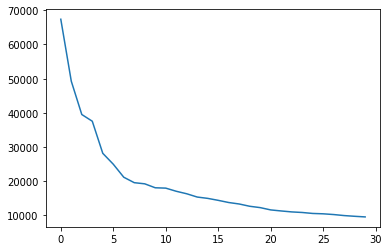

In [ ]:
# how the SVD sigma values decay
plt.plot([sigma[i] for i in range(30)])

## Visualize one eigenface

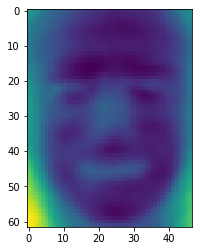

In [ ]:
plt.imshow(VT[0].reshape(62,47))
# don't need to transpose V.

## Compress image to components

In [ ]:
# convert any image to eigenfaces
original = lfw_dataset.images[0].reshape(62*47)
# plt.imshow(original)
# take top 20 vectors
components = np.matmul(original, VT[:30,:].T)

In [ ]:
# now try combining them
combined = np.matmul(components, VT[:30,:])

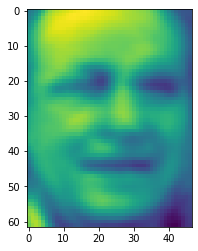

In [ ]:
plt.imshow(combined.reshape(62,47))

## Comparison with original

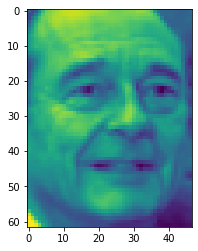

In [ ]:
# compare with original
plt.imshow(original.reshape(62,47))

In [ ]:
components.shape # this is how much data per frame of face

(30,)

## Generalized approach

In [ ]:
from PIL import Image
# example with small image list.
image_list = ["IMG_8980.JPG",
              "IMG_8981.JPG",
              "IMG_8982.JPG",
              "IMG_8983.JPG",
              "IMG_8984.JPG",
              "IMG_8985.JPG",
              "IMG_8986.JPG",
              "IMG_8987.JPG"]

images = []
for image in image_list:
  im = np.array(Image.open(image))/255
  images.append(im)

image_data = np.stack(images)

In [ ]:
image_data.shape

(8, 480, 640, 3)

In [ ]:
plt.imshow(image_data[0])

In [ ]:
avg_image = np.average(image_data, axis=0)
# need to convert all values to integers or else it wont plot, bc 0-1 for floats
# and 255 for integers.

plt.imshow(avg_image)

In [ ]:
centered_images = image_data - avg_image

In [ ]:
reshaped = centered_images.reshape(8, 480*640, 3)

In [ ]:
R = reshaped[:,:,0]
G = reshaped[:,:,1]
B = reshaped[:,:,2]

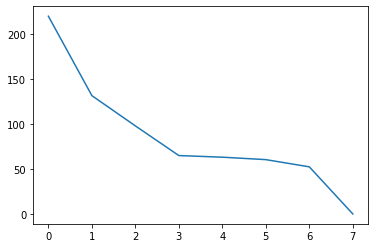

In [ ]:
# do SVD on each
# red channel

U, sigma, VT = np.linalg.svd(R, full_matrices=False)
plt.plot([sigma[i] for i in range(8)]) # only 8 bc 8 max images

In [ ]:
# first eigenface
plt.imshow(VT[0].reshape(480,640))

In [ ]:
# components
# convert any image to eigenfaces

# red channel only
original = image_data[0].reshape(480*640, 3)[:,0]

In [ ]:
# double check
plt.imshow(original.reshape(480,640))

In [ ]:
# take top 8 vectors
components = np.matmul(original, VT[:8,:].T)

In [ ]:
# reconstruct
combined = np.matmul(components, VT[:8,:])
plt.imshow(combined.reshape(480,640))

In [ ]:
# repeat for other channels.

# Final version: Read images and Get Eigenfaces

## Key functions

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def read_images(image_list):
  """image_list: names of images"""
  images = []
  for image in image_list:
    im = np.array(Image.open(image))/255
    images.append(im)

  image_data = np.stack(images)
  return image_data # num_img, x, y, 3

def get_avg_face(image_data):
  """avg face: x, y, 3 dimensions with 3 rgb channels"""
  avg = np.average(image_data, axis=0)
  assert avg.shape == image_data.shape[1:]
  assert avg.shape[2] == 3
  return avg

def subtract_avg_face(image_data, avg_face):
  """centered images"""
  return image_data - avg_face

def svd_one_channel(image_one_channel):
  """input image: dims n, x,y"""
  shape = image_one_channel.shape
  assert len(shape) == 3

  # reshape before svd
  reshaped = image_one_channel.reshape(shape[0], shape[1]*shape[2])
  U, sigma, VT = np.linalg.svd(reshaped, full_matrices=False)
  return U, sigma, VT

def plot_decay(sigma):
  """plot sigma component decay pca"""
  plt.plot([sigma[i] for i in range(len(sigma))]) # can cap this later

def compress(image_channel, VT, num_comp):
  """input x, y image single image"""
  shape = image_channel.shape
  reshaped = image_channel.reshape(shape[0]*shape[1])
  rcomponents = np.matmul(reshaped, VT[:num_comp,:].T)
  return rcomponents

def reconstruct(rcomponents, VT, num_comp):
  """components for single channel"""
  combined = np.matmul(rcomponents, VT[:num_comp,:])
  return combined # x*y one-D vector

def compare(original, full_reconstructed):
  """show original vs components"""
  f, subf = plt.subplots(1,2)
  subf[0].imshow(original)

  # right now only 1 channel so 0:2
  subf[1].imshow(full_reconstructed.reshape(original.shape))
  

## Example run

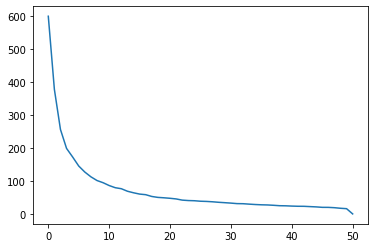

In [ ]:
plot_decay(sigmar) # use this to pick num_comp

## Prepare image data, perform compression

In [ ]:
# reference: https://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames
import cv2
vid = cv2.VideoCapture('stockvideo_pixabay.mp4') #2.4 MB, 25 fps; total 50 frames
# check how many frames this is later...
# pexels_face_talking: 24+ fps, 509 frames 21 sec. 747kb

success, image = vid.read()
idx = 0

while success: # continue reading
  # save locally.
  cv2.imwrite("frame%d.jpg" % idx, image)     # frame to .jpg      
  success, image = vid.read()
  idx += 1

In [ ]:
image_list = ["frame" + str(i) + ".jpg" for i in range(510)]

Be sure to run "Key functions" before this.

In [ ]:
def compress_image_list(image_list, num_comp=10):
  image_data = read_images(image_list)
  # print(image_data.shape)
  avg_face = get_avg_face(image_data)
  centered = subtract_avg_face(image_data, avg_face)
  rchannel = centered[:,:,:,0]
  gchannel = centered[:,:,:,1]
  bchannel = centered[:,:,:,2]

  ur, sigmar, vtr = svd_one_channel(rchannel)
  ug, sigmag, vtg = svd_one_channel(gchannel)
  ub, sigmab, vtb = svd_one_channel(bchannel)

  # num_comp = 10
  for image_index in range(len(image_list)):
  # image_index = 7
    rcomponents = compress(rchannel[image_index], vtr, num_comp)
    gcomponents = compress(gchannel[image_index], vtg, num_comp)
    bcomponents = compress(bchannel[image_index], vtb, num_comp)

    np.save('image'+str(image_index) + 'r', rcomponents)
    np.save('image'+str(image_index) + 'g', gcomponents)
    np.save('image'+str(image_index) + 'b', bcomponents)


  np.save('average', avg_face)
  np.save('eigenr', vtr[:num_comp, :])
  np.save('eigeng', vtg[:num_comp, :])
  np.save('eigenb', vtb[:num_comp, :])

  plot_decay(sigmar)


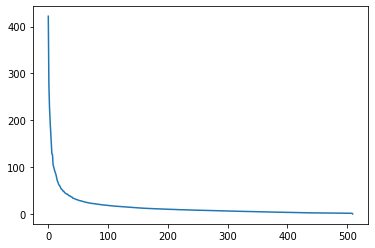

In [ ]:
compress_image_list(image_list)

## Reconstruct images and video

In [ ]:
# can decide on num_comp based on decay here.
num_comp = 25

In [ ]:
# make sure to use correct shape.
im = np.array(Image.open("frame0.jpg"))/255

In [ ]:
im.shape

(360, 640, 3)

Processing image 25
Processing image 50
Processing image 75
Processing image 100
Processing image 125
Processing image 150
Processing image 175
Processing image 200
Processing image 225
Processing image 250
Processing image 275
Processing image 300
Processing image 325
Processing image 350
Processing image 375
Processing image 400
Processing image 425
Processing image 450
Processing image 475
Processing image 500


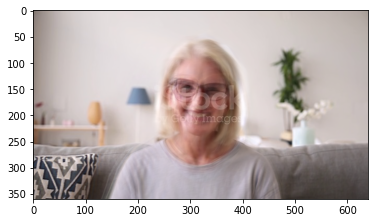

In [ ]:
# read components from image_components.txt
# read average face from average_and_eigen.txt
# size is just the size i forgot to save this , 720 times 1080 i think
import os.path

avg_face = np.load('average.npy')
vtr = np.load('eigenr.npy')
vtg = np.load('eigeng.npy')
vtb = np.load('eigenb.npy')

# uncomment if needed
# num_comp = len(vtr)

img_idx = 0
while os.path.isfile('image'+str(img_idx) + 'r.npy'):
  rcomponents = np.load('image'+str(img_idx) + 'r.npy')
  gcomponents = np.load('image'+str(img_idx) + 'g.npy')
  bcomponents = np.load('image'+str(img_idx) + 'b.npy')

  rreconstructed = reconstruct(rcomponents, vtr, num_comp)
  greconstructed = reconstruct(gcomponents, vtg, num_comp)
  breconstructed = reconstruct(bcomponents, vtb, num_comp)
  # print(rreconstructed.shape)

  full_reconstructed = np.stack([rreconstructed, greconstructed, breconstructed], axis=1)
  full_reconstructed = full_reconstructed.reshape(im.shape) # double check this
  # print(full_reconstructed.shape)

  full_reconstructed_plus_avg = full_reconstructed + avg_face

  adjusted = full_reconstructed_plus_avg.clip(0, 1)
  plt.imshow(adjusted)
  plt.imsave("outputimage"+str(img_idx)+".jpg", adjusted)

  img_idx += 1

  if img_idx % 25 == 0:
    print("Processing image", img_idx)


In [ ]:
import moviepy.video.io.ImageSequenceClip
images = [i for i in os.listdir('.') if 'outputimage' in i]

In [ ]:
def imgnum(img):
  x = img.replace("outputimage","")
  x = x.replace(".jpg", "")
  return int(x)
  
images.sort(key=imgnum)

In [ ]:
fps = 25 #original
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(images, fps=fps)
clip.write_videofile('output_video.mp4')

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|██████████| 510/510 [00:07<00:00, 66.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 



In [ ]:
from google.colab import files
files.download("output_video.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Compare the size if we put all numbers into a text file

In [ ]:
npy_files = [i for i in os.listdir('.') if '.npy' in i and 'image' in i]

with open("all_npy_nums.txt", 'w') as f:
  for file in npy_files:
    array = np.load(file)
    string_out = np.array2string(array, precision=4)
    f.write(string_out)
  f.close()

In [ ]:
files.download("all_npy_nums.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>